In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

In [87]:
data = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/masculinity-survey/masculinity-survey.csv")

one_hot = pd.read_csv("one-hot-responses.csv")
# Very masculine, Somewhat masculine, Not very masculine, Not at all masculine
masculinity_scale = [col for col in one_hot.columns if col.startswith('q0001')]
# Straight, Gay, Bisexual, Other
sexuality_scale = [col for col in one_hot.columns if col.startswith('q0026')]
# print(masculinity_scale)
print(sexuality_scale)

# top n pca
n = 20
predictors = [one_hot.columns[i] for i in range(7, len(one_hot.columns))]
X = one_hot[predictors].values.T
n_i, n_j = X.shape
stds = np.std(X, axis=1)
stds = np.repeat(np.reshape(stds, (-1,1)), n_j, axis=1)
S = X/stds
pcs = PCA(n_components=n).fit_transform(S.T)
df_pcs = pd.DataFrame(pcs, columns=['PC'+str(i+1) for i in range(n)])
df_pcs['y'] = one_hot['q0026_Gay'].values

mean_mses = []
kf = KFold(n_splits=10, shuffle=True)
pc_numbers = [i+1 for i in range(50)]
# linear models using top k=1,2,3,...,20
for num_pc in pc_numbers:
    # do 10-fold cross validation
    train_mses = []
    test_mses = []
    for train_idx, test_idx in kf.split(df_pcs):
        df_train = df_pcs.iloc[train_idx, :]
        df_test = df_pcs.iloc[test_idx, :]
        
        # generate formula
        formula = 'y ~ 1'
        for num in range(1, num_pc+1):
            formula += (' + PC%d' % num)
            
        # fit model with df_train
        res = smf.ols(formula=formula, data=df_train).fit()

        # MSE of training set
        train_pred = res.predict(df_train)
        mse_train = np.mean((train_pred - df_train.y)**2)

        # MSE of test set
        test_pred = res.predict(df_test)
        mse_test = np.mean((test_pred - df_test.y)**2)

        # store results
        train_mses.append(mse_train)
        test_mses.append(mse_test)



    # report average training MSE and testing MSE
    mean_train_mse = np.mean(train_mses)
    mean_test_mse = np.mean(test_mses)
    
    mean_mses.append({'num_pc': num_pc,
                      'formula': formula,
                    'mean_train_mse': mean_train_mse,
                     'mean_test_mse': mean_test_mse})
    
    
df_res = pd.DataFrame(mean_mses)
df_res

['q0026_Bisexual', 'q0026_Gay', 'q0026_No answer', 'q0026_Other', 'q0026_Straight']


,formula,mean_test_mse,mean_train_mse,num_pc
0,y ~ 1 + PC1,0.064112,0.063916,1
1,y ~ 1 + PC1 + PC2,0.055278,0.054926,2
2,y ~ 1 + PC1 + PC2 + PC3,0.048153,0.047763,3
3,y ~ 1 + PC1 + PC2 + PC3 + PC4,0.047746,0.047244,4
4,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5,0.046877,0.046342,5
5,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6,0.045995,0.045187,6
6,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7,0.043186,0.042603,7
7,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.043254,0.042558,8
8,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.041715,0.041061,9
9,y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...,0.041914,0.041043,10


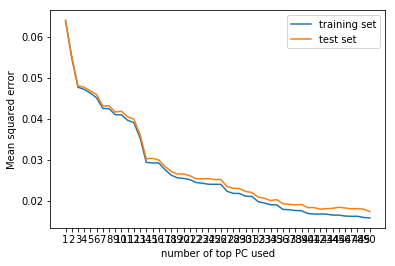

/Users/Shirley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  if __name__ == '__main__':


formula           y ~ 1 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC...
mean_test_mse                                             0.0174308
mean_train_mse                                            0.0158876
num_pc                                                           50
Name: 49, dtype: object

In [88]:
fig, ax = plt.subplots()
ax.plot(df_res.num_pc, df_res.mean_train_mse, label='training set')
ax.plot(df_res.num_pc, df_res.mean_test_mse, label='test set')
ax.legend()
ax.set_xticks(df_res.num_pc.values)
ax.set_xlabel('number of top PC used')
ax.set_ylabel('Mean squared error')
plt.show()
best_model = df_res.loc[df_res.mean_test_mse.argmin()]
best_model